In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

get_ipython().run_line_magic('matplotlib', 'notebook')


class importTickerData:
    def __init__(self, ticker, start, end):
        self.ticker = ticker 
        self.start = start
        self.end = end
        
    def importData(self):
        df = pd.read_csv(self.ticker)
        df = df[['Date', 'Close']]
        df = df.set_index(['Date'])
        df = df.loc[self.start:self.end]
        df = df.dropna()
        df = df.reset_index()
        return df

#Downloading GLD data
importGLD = importTickerData("GLD.csv", "2005-01-01", "2021-07-29")
gold_data = importGLD.importData()
gold_data.tail()


,Date,Close
4166,2021-07-22,169.089996
4167,2021-07-23,168.559998
4168,2021-07-26,168.160004
4169,2021-07-27,168.440002
4170,2021-07-28,169.289993


In [2]:
#Dowloading and formating 10-Years Tresury Yield Data

importTNX = importTickerData("^TNX.csv", "2005-01-01", "2021-07-29")
treasury_10y_yield_df = importTNX.importData()
treasury_10y_yield_df.tail()


,Date,Close
4128,2021-07-22,1.265
4129,2021-07-23,1.286
4130,2021-07-26,1.276
4131,2021-07-27,1.234
4132,2021-07-28,1.261


In [3]:
# Calculating a correlation between yields and gold prices

df_merged = pd.merge(gold_data, treasury_10y_yield_df, on='Date', suffixes = (' Gold', ' Yield'))

df_merged = df_merged.set_index('Date')
df_merged.corr(method='pearson')

# Negative Correlation of -0.858

,Close Gold,Close Yield
Close Gold,1.000000,-0.858136
Close Yield,-0.858136,1.000000


<IPython.core.display.Javascript object>


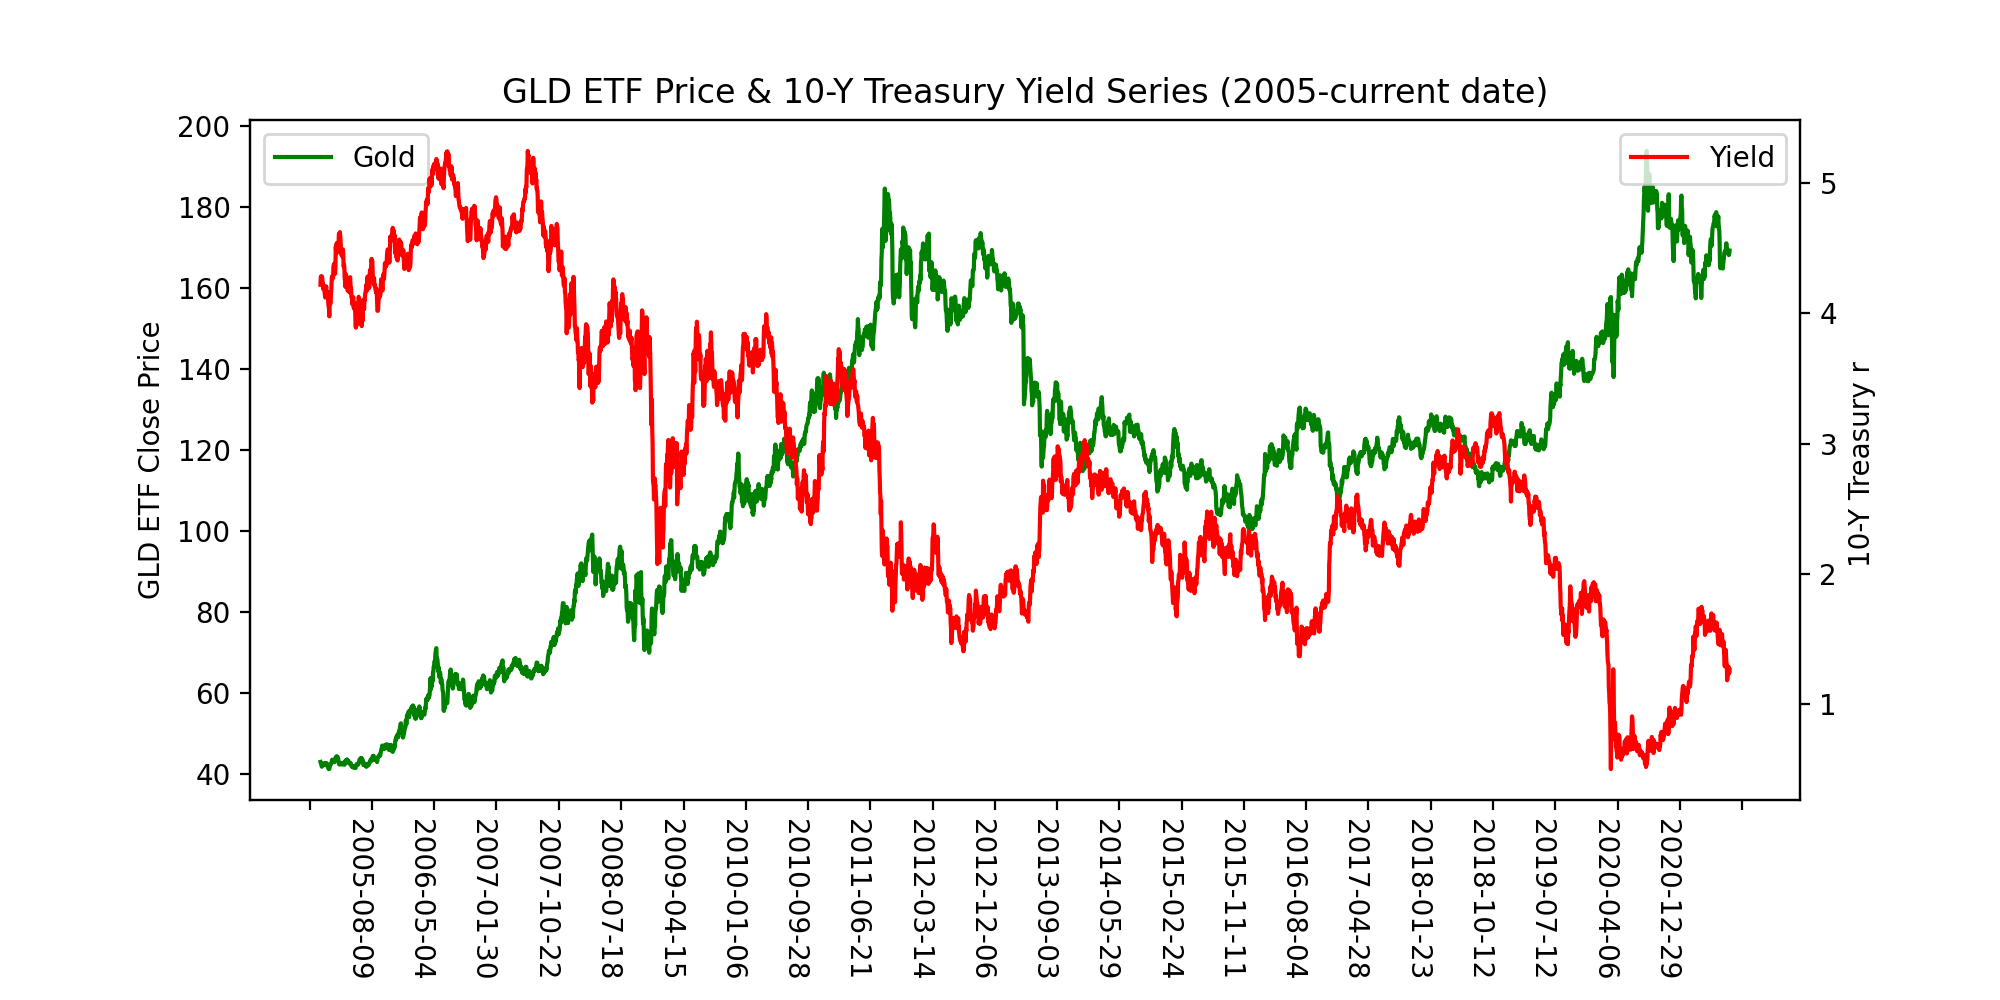

In [22]:
# Plotting a simple graph to check the data

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

ax.set_ylabel("GLD ETF Close Price")
ax.set_title("GLD ETF Price & 10-Y Treasury Yield Series (2005-current date)")
ax.plot(df_merged.index, 'Close Gold', data=df_merged, color='g')

ax2 = ax.twinx()
ax2.plot(df_merged.index, 'Close Yield', data=df_merged, color='r')
ax2.set_ylabel("10-Y Treasury r ")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.legend(['Gold'])
ax2.legend(['Yield'])
fig.autofmt_xdate(rotation=270)



Linear model coeff (w): [-27.30397718]
Linear model intercept (b): 190.874
R-squared score (training): 0.667
R-squared score (test): 0.789
Gold Price = -27.30 * Yield  + 190.87 


<IPython.core.display.Javascript object>


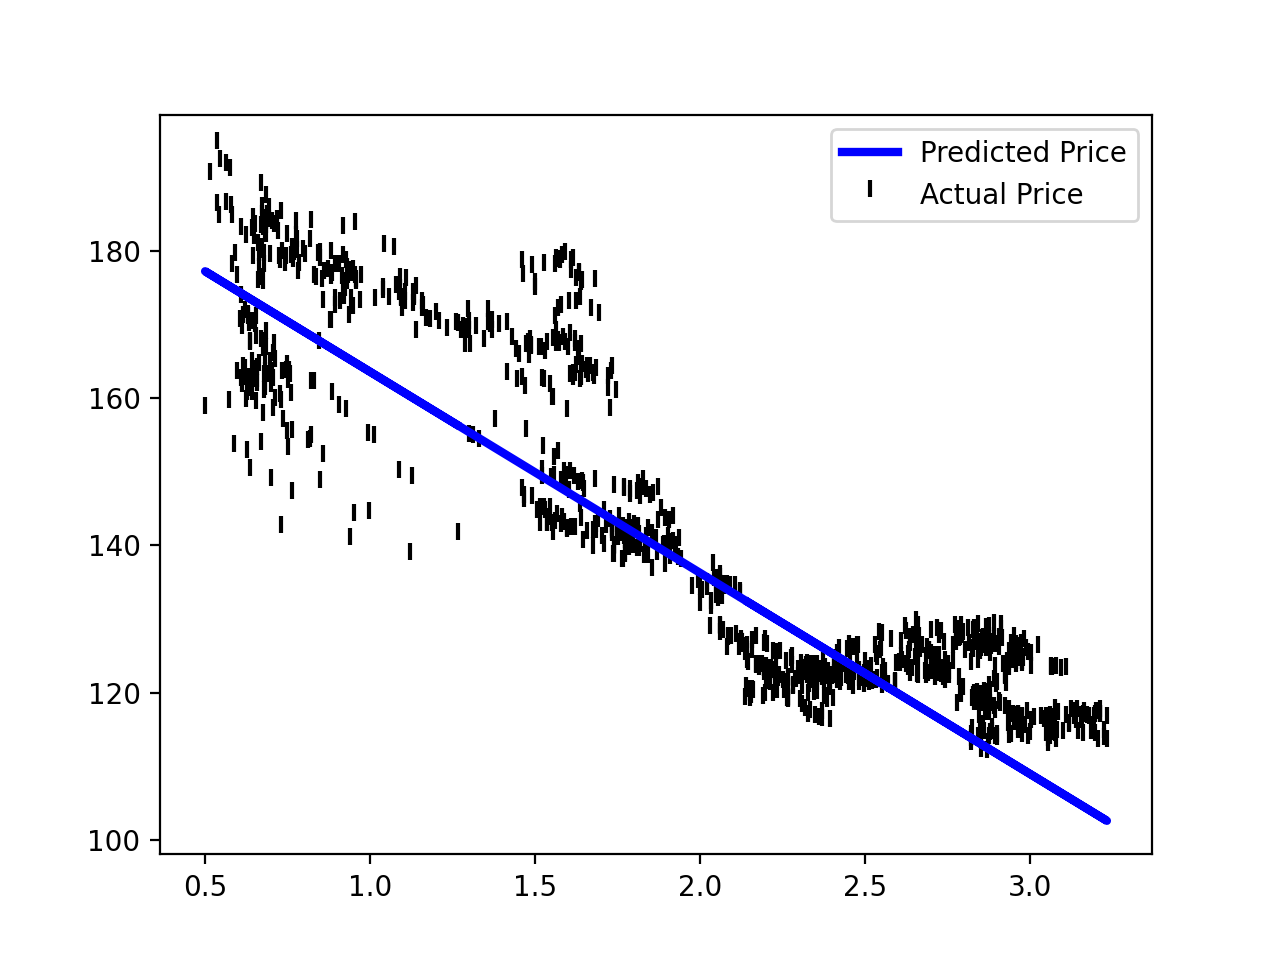

In [23]:
# Linear Regression Model

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split



X = df_merged[['Close Yield']]
y = df_merged['Close Gold']



X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, stratify=None)
linreg =  LinearRegression().fit(X_train, y_train)

predicted_price = linreg.predict(X_test)


print('Linear model coeff (w): {}'
     .format(linreg.coef_))
print('Linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))
print("Gold Price = %.2f * Yield  \
+ %.2f " % (linreg.coef_[0], linreg.intercept_))


# Plot Data
fig4, ax4 = plt.subplots()
plt.scatter(X_test, y_test, marker=2, color='black')
plt.plot(X_test, predicted_price, color='blue', linewidth=3)

plt.show()

<IPython.core.display.Javascript object>


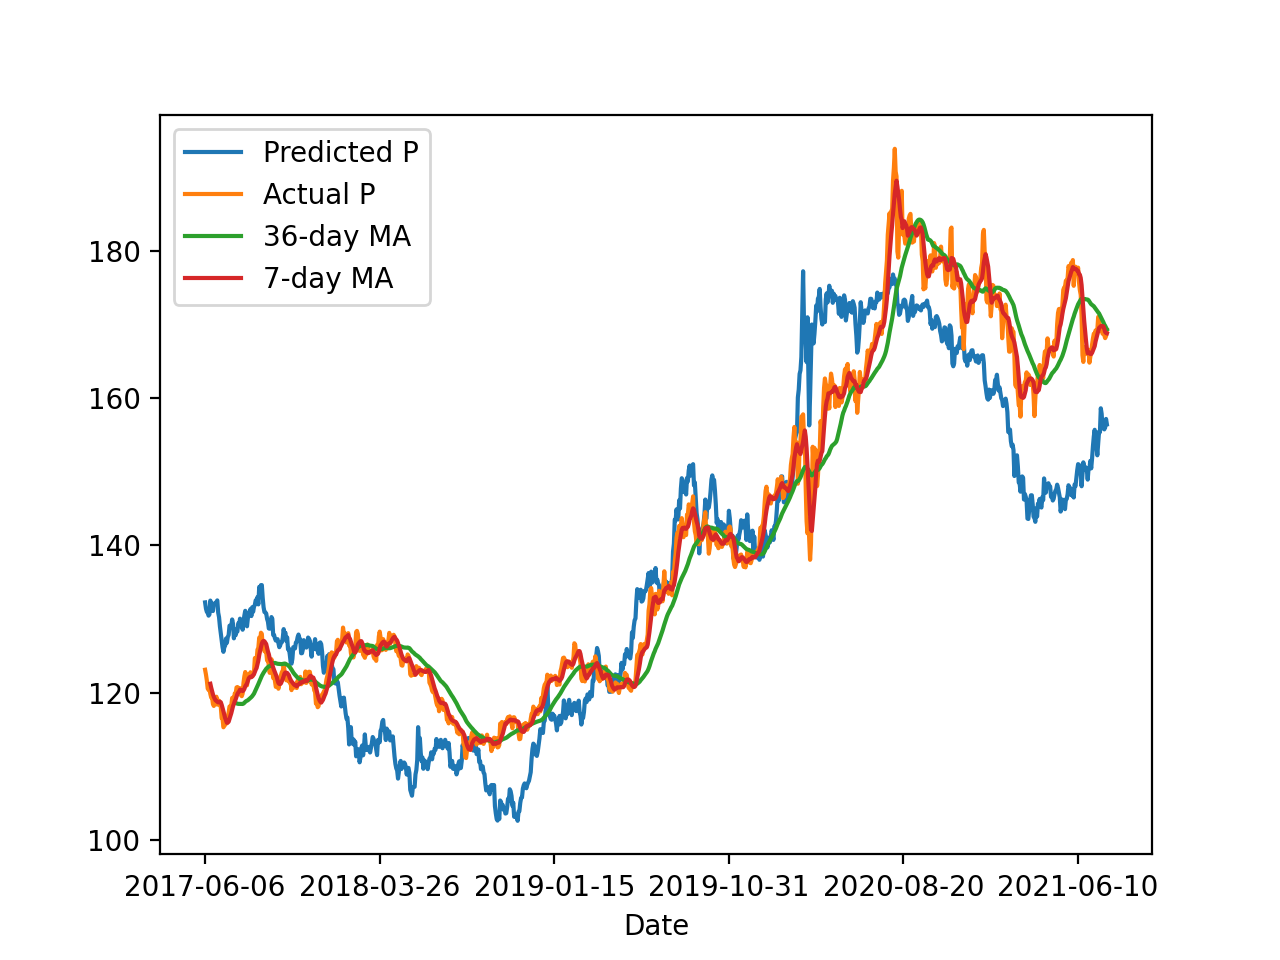

<AxesSubplot:xlabel='Date'>

In [24]:
# Plotting the predicted, actual price
DF_test = pd.DataFrame(index=y_test.index)
DF_test['Predicted P'] = predicted_price
DF_test['Actual P'] = y_test
DF_test['36-day MA'] = y_test.rolling(window=36).mean()
DF_test['7-day MA'] = y_test.rolling(window=7).mean()
plt.legend(['Predicted Price', 'Actual Price', '14-day MA'])

DF_test.plot()


In [40]:
# Backtesting simple long/exit position strategy: 

# A few important details:
# Initial amount = $1000
# Return is calculated assuming cumulative product (one bet = whole account) and the position is made
# exactly at the close price
# This model doesn't include trascations/broker fees costs (they will obviously reduce a return),
# but lets asume we use zero commissions broker.
# Also, this model simplifies the fact that shares cannot be bought with fractions or precisely with our bet amount
# like (e.g $1000 for GLD P=$190 can buy 5.26 shares)


DF1 = pd.DataFrame()
     
t = .75
t = int(t*len(y))
DF1['P'] = y[t:]
DF1['r'] = X[t:]
DF1['Predicted P'] = predicted_price
DF1['Actual P'] = y_test
DF1['Gold %'] = DF1['P'].pct_change().shift(-1)
DF1['Signal'] = np.where(DF1['Predicted P'].shift(1) < DF1['Predicted P'], 1, 0)


DF1['GLD %'] = GLD_DF['Close'].pct_change().shift(-1)
DF1['$1000 Benchmark'] = 1000*(DF1['GLD %']+1).cumprod()

 
# Moving Average Slope Signal
DF1['36-day MA'] = y_test.rolling(window=36).mean()
DF1['7-day MA'] = y_test.rolling(window=7).mean()

# MA Slope Derivatives Signals
DF1 = DF1.assign(MA_Slope = lambda x: (DF1['36-day MA'] - DF1['36-day MA'].shift(1))/1)
DF1 = DF1.assign(Slope_Deriv = lambda x: (DF1['MA_Slope'] - DF1['MA_Slope'].shift(1))/1)

# Positive Slope
DF1['Signal2'] = np.where(DF1['MA_Slope'] > 0, 1, 0) 
# Momentum
DF1['Signal3'] = np.where(DF1['Slope_Deriv'] > 0, 1, 0)
# MA Crossover
DF1['Signal4'] = np.where(DF1['7-day MA'] > DF1['36-day MA'], 1, 0) 


# Strategy Signal Main 
DF1 = DF1.assign(SignalComb = lambda x: DF1['Signal2'] + DF1['Signal3'] + DF1['Signal4'])
DF1['SignalMain'] = np.where(np.logical_or(
                                            np.logical_and(np.greater(DF1.Signal, 0), np.greater(DF1.Signal3, 0)), 
                                            np.logical_and(np.greater(DF1.Signal, 0), np.greater(DF1.Signal4, 0))), 
                             1, 0)
# Multi Signal Stategy 
DF1['SignalFINAL'] = np.where(np.logical_or(np.greater(DF1.SignalComb, 2), np.greater(DF1.SignalMain, 0)), 1, 0)

# Computing Returns
DF1 = DF1.assign(StrategyGLD = lambda x: x['GLD %']*x['SignalFINAL'])
DF1['Profit Account Bet'] = 1000*(DF1['StrategyGLD']+1).cumprod()

# Equal $1000 Bet Returns
DF1['Profit Equal $1000 Bet'] = (1000*(DF1['StrategyGLD']+1)-1000)
DF1['Total Profit'] = (DF1['Profit Equal $1000 Bet']).cumsum()
DF1['Account'] = (DF1['Total Profit'])+1000

DF1.tail()


,P,r,Predicted P,Actual P,Gold %,Signal,GLD %,$1000 Benchmark,36-day MA,7-day MA,...,Signal3,Signal4,SignalComb,SignalMain,SignalFINAL,StrategyGLD,Profit Account Bet,Profit Equal $1000 Bet,Total Profit,Account
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-22,169.089996,1.265,156.334199,169.089996,-0.003134,1,-0.003134,1379.092967,170.314722,169.767142,...,1,0,1,1,1,-0.003134,1617.83684,-3.134414,501.784376,1501.784376
2021-07-23,168.559998,1.286,155.760816,168.559998,-0.002373,0,-0.002373,1375.820371,170.031111,169.412857,...,0,0,0,0,0,-0.000000,1617.83684,0.000000,501.784376,1501.784376
2021-07-26,168.160004,1.276,156.033856,168.160004,0.001665,1,0.001665,1378.111206,169.833611,168.997142,...,1,0,1,1,1,0.001665,1620.53065,1.665069,503.449445,1503.449445
2021-07-27,168.440002,1.234,157.180623,168.440002,0.005046,1,0.005046,1385.065505,169.591389,168.858571,...,0,0,0,0,0,0.000000,1620.53065,0.000000,503.449445,1503.449445
2021-07-28,169.289993,1.261,156.443415,169.289993,NaN,0,NaN,NaN,169.353055,168.812855,...,1,0,1,0,0,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


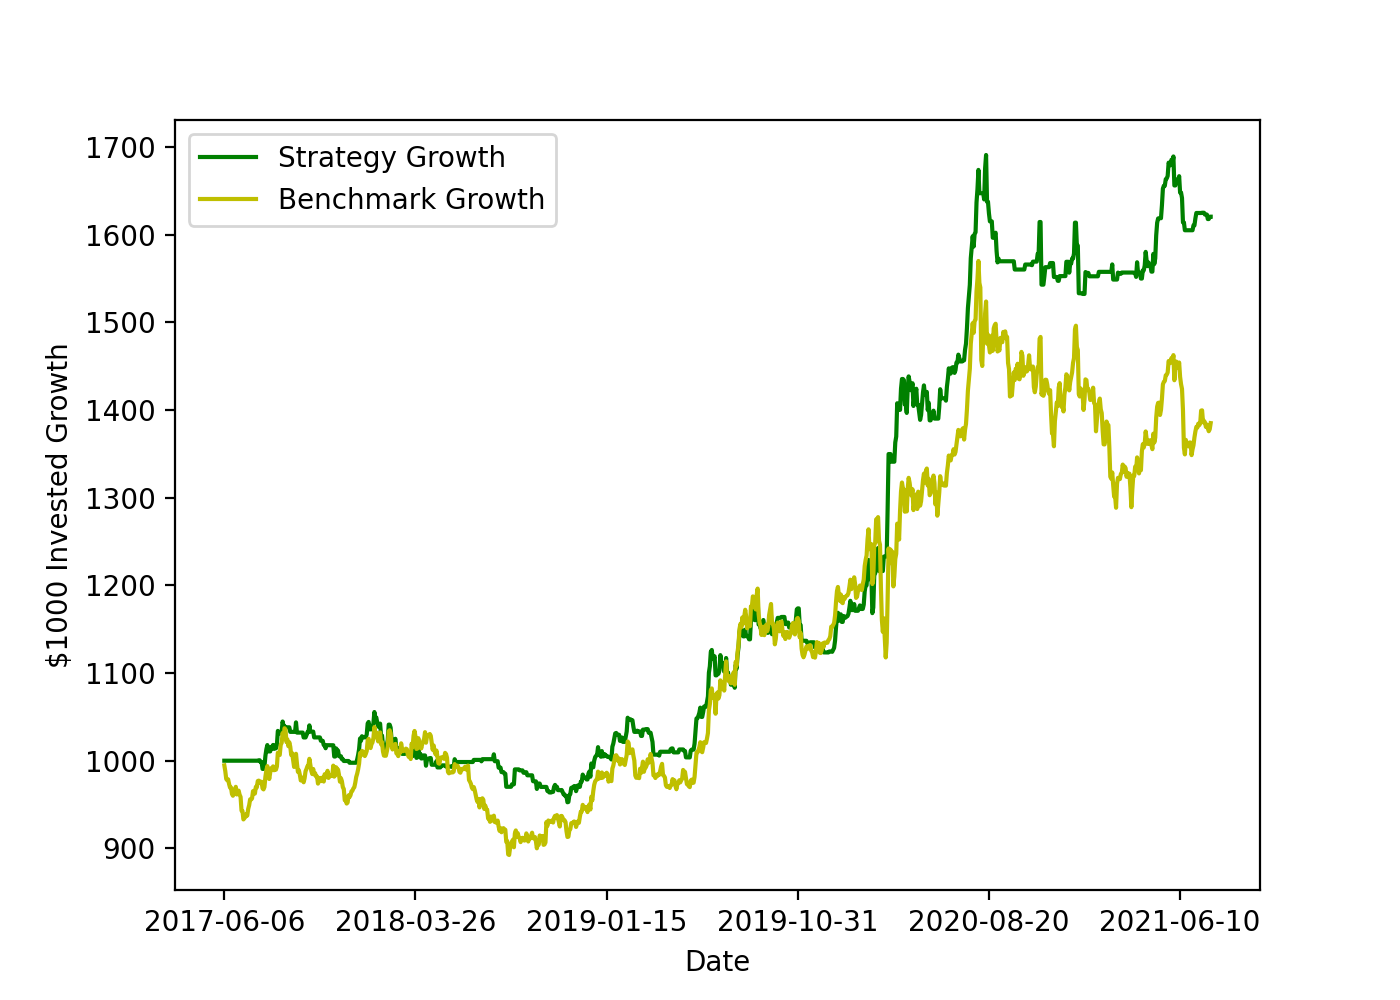

In [41]:
# Plotting returns
fig3, ax3 = plt.subplots()

DF1['Profit Account Bet'].plot(figsize=(7, 5), color='g')
DF1['$1000 Benchmark'].plot(color='y')

plt.ylabel('$1000 Invested Growth')
plt.legend(['Strategy Growth', 'Benchmark Growth'])
plt.show()


In [46]:
# Sharpe Ratio

sharpe = DF1['StrategyGLD'].mean()/DF1['StrategyGLD'].std()*np.sqrt(252)
'Sharpe Ratio %.2f' % (sharpe)

'Sharpe Ratio 1.22'